In [10]:
%pip install python-chess==0.31.3 tensorflow pydot

Note: you may need to restart the kernel to use updated packages.


In [2]:
import chess
import chess.engine
import random
import numpy

def random_board(max_depth=200):
  board = chess.Board()
  depth = random.randrange(0, max_depth)

  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break

  return board

def stockfish(board, depth):
  with chess.engine.SimpleEngine.popen_uci("stockfish") as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result["score"].white().score()
    return score
  

893


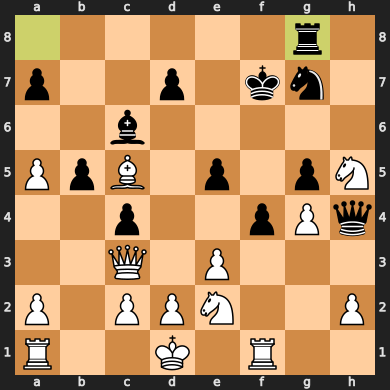

In [5]:
board = random_board()
print(stockfish(board, 0))
board

In [3]:
squares_index = {
    "a": 0,
    "b": 1,
    "c": 2,
    "d": 3,
    "e": 4,
    "f": 5,
    "g": 6,
    "h": 7
}

def square_to_index(square: chess.Square):
    letter = chess.square_name(square)
    return 8 - int(letter[1]), squares_index[letter[0]]

def split_dims(board: chess.Board):

    board3d = numpy.zeros((14,8,8), dtype=numpy.int8)

    for piece in chess.PIECE_TYPES:
        for stm in {True, False}:
            for square in board.pieces(piece, stm):
                idx = numpy.unravel_index(square, (8,8))
                board3d[piece + (-1 if stm else 5)][7-idx[0]][idx[1]] = 1

    aux = board.turn
    for stm in {True, False}:
        board.turn = stm
        for move in board.legal_moves:
            i, j = square_to_index(move.to_square)
            board3d[12 if stm else 13][i][j] = 1
    board.turn = aux

    return board3d

In [6]:
split_dims(board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [2]:
import tensorflow as tf
layers = tf.keras.layers

def build_model(conv_size, conv_depth):
    board3d = tf.keras.layers.Input(shape=(14,8,8))

    x = board3d

    for _ in range(conv_depth):
        x = tf.keras.layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, 'relu')(x)
    x = tf.keras.layers.Dense(1, 'tanh')(x)
    return tf.keras.models.Model(inputs=board3d, outputs=x)

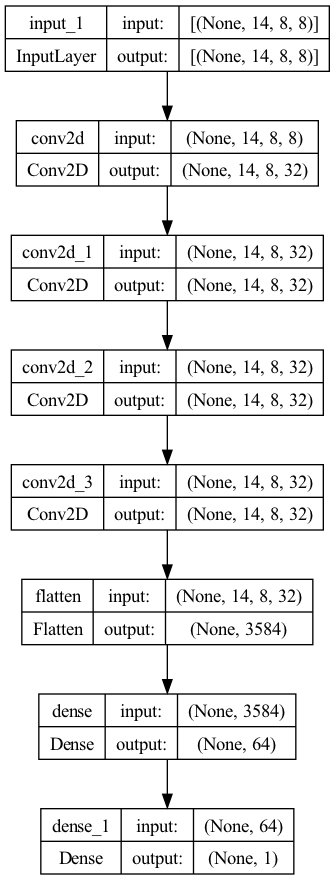

In [3]:
model = build_model(32, 4)
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)